# 원리

* LinearSCV는 class간 margin을 최대한 키우는 방식
* 커널방식은 단순한 LinearSVC 로 정의되지 않는 더 복잡한 모델을 만들 수 있도록 확장

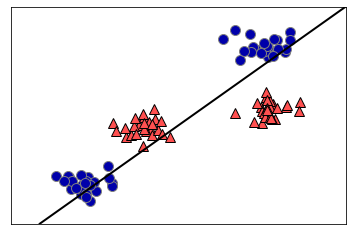

In [1]:
from ml1.preamble import*
from sklearn.datasets import make_blobs
Xb,yb = make_blobs(centers=4, random_state=8)
yb= yb%2

from sklearn.svm import LinearSVC
linear_svm = LinearSVC(max_iter=10000).fit(Xb, yb)
mglearn.plots.plot_2d_separator(linear_svm, Xb)
mglearn.discrete_scatter(Xb[:,0], Xb[:,1], yb)

=> 선형 모델로는 위 데이터를 잘 분류할 수 없음<br>
=> 새로운 특성을 추가하여 차원을 늘려서 해결 가능<br><br>

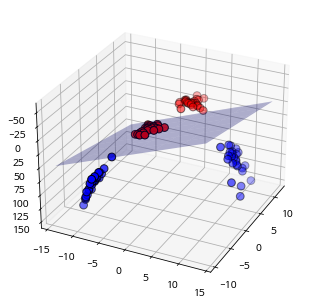

In [2]:
# 새 특성 추가
Xb_new = np.hstack([Xb,Xb[:,1:]**2])

# 모델 생성
linear_svm = LinearSVC(max_iter=10000).fit(Xb_new, yb)
coef, intercept = linear_svm.coef_.ravel(), linear_svm.intercept_

# 결정 경계
xx = np.linspace(Xb_new[:,0].min()-2, Xb_new[:,0].max()+2, 50)
yy = np.linspace(Xb_new[:,1].min()-2, Xb_new[:,1].max()+2, 50)
XX,YY  = np.meshgrid(xx, yy)
ZZ = (coef[0]*XX + coef[1]*YY + intercept)/-coef[2]

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
ax.plot_surface(XX,YY,ZZ, rstride=8, cstride=8, alpha=0.3)
y0 = (yb==0)
ax.scatter(Xb_new[y0, 0], Xb_new[y0, 1], Xb_new[y0,2], c='b', s=60, ec='k')
ax.scatter(Xb_new[~y0, 0], Xb_new[~y0, 1], Xb_new[~y0,2], c='r', s=60, ec='k')

=> 확장된 차원에선 선형으로 잘 분리가 된 모습

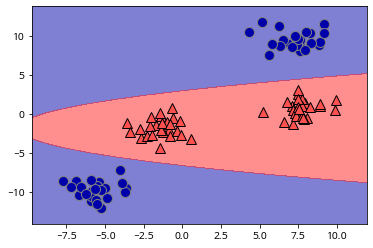

In [3]:
dec = linear_svm.decision_function(np.c_[XX.ravel(), YY.ravel(),(YY**2).ravel()])
plt.contourf(XX,YY,dec.reshape(XX.shape), levels=[dec.min(),0,dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(Xb[:,0], Xb[:,1], yb)

=> 원래 차원으로 투영하면 더 이상 선형이 아닌 것을 확인<br><br>

* 특성을 추가하는 것은 비용이 크므로 실제로는 커널 기법을 사용
* 커널 기법은 확장된 특성에 대한 데이터 포인트들의 거리를 계산
* 커널은 대표적으로 2가지가 있음
    * 다항식 커널 : 원래 특성의 가능한 조합을 지정된 차수까지 모두 계산
    * 가우시안 커널 : 무한한 특성 공간에 매핑

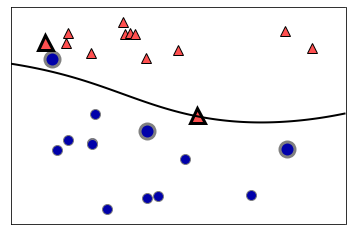

In [4]:
X,y = mglearn.tools.make_handcrafted_dataset()

from sklearn.svm import SVC
svm= SVC(kernel='rbf', C=10, gamma=.1).fit(X,y)
sv = svm.support_vectors_
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(X[:,0], X[:,1], y)
mglearn.discrete_scatter(sv[:,0], sv[:,1], sv_labels, s=15, markeredgewidth = 3)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)

# 매개변수 C와 gamma

* gamma : 커널의 폭의 역수, 클수록 샘플의 영향력이 적어짐
* C : 규제 매개변수, 클수록 마진의 크기보다 분류를 얼마나 더 잘햇는지에 가중치를 둠

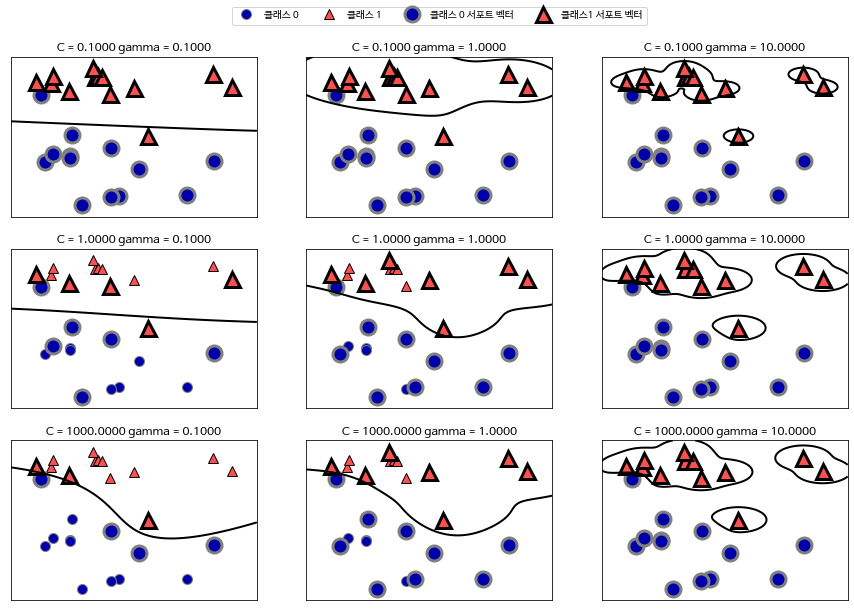

In [5]:
fig, axes = plt.subplots(3,3, figsize=(15,10))
for ax, C in zip(axes,[-1, 0, 3]):
    for a, gamma, in zip(ax, range(-1,2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
axes[0,0].legend(['클래스 0', '클래스 1', '클래스 0 서포트 벡터', '클래스1 서포트 벡터'],
                ncol=4, loc=(.9,1.2))

# 코드

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state =0)

svc= SVC(gamma='auto').fit(X_train, y_train)     # gamma의 기본값은 scale로 scale 조정 안된 특성에서 더 좋음
print(f"훈련 세트 정확도 : {svc.score(X_train, y_train):.2f}")
print(f"테스트 세트 정확도 : {svc.score(X_test, y_test):.2f}")

훈련 세트 정확도 : 1.00
테스트 세트 정확도 : 0.63


=> SVM은 데이터 스케일에 민감

# SVM을 위한 데이터 전처리

* 각 특성의 분포를 시각화

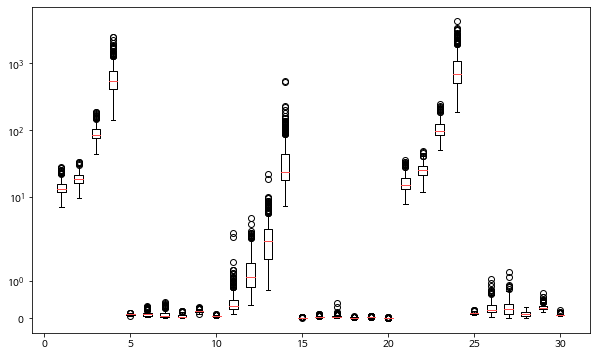

In [7]:
plt.figure(figsize=(10,6))
plt.boxplot(X_train, manage_ticks=False)
plt.yscale('symlog')

=> 차이가 매우 큼 : SVM에게는 치명적<br><br>

* MinMax를 이용한 스케일 조정

In [8]:
X_min = X_train.min(axis=0)
X_range = (X_train -X_min).max(axis=0)

X_train_scaled = (X_train - X_min)/X_range
X_test_scaled = (X_test -X_min)/X_range

svc = SVC(gamma='auto').fit(X_train_scaled, y_train)
print(f"훈련 세트 정확도 : {svc.score(X_train_scaled, y_train):.2f}")
print(f"테스트 세트 정확도 : {svc.score(X_test_scaled, y_test):.2f}")

훈련 세트 정확도 : 0.95
테스트 세트 정확도 : 0.95


=> 과소적합일 가능성 있으니 C를 증가

In [9]:
svc = SVC(gamma='auto', C=1000).fit(X_train_scaled, y_train)
print(f"훈련 세트 정확도 : {svc.score(X_train_scaled, y_train):.2f}")
print(f"테스트 세트 정확도 : {svc.score(X_test_scaled, y_test):.2f}")

훈련 세트 정확도 : 0.99
테스트 세트 정확도 : 0.97


# 장단점

## 장점

* 저차원 고차원에서 모두 잘 작동함

## 단점

* 데이터가 너무 많을 시 속도가 느림
* 전처리와 매개변수에 민감함